In [1]:
import numpy as np
import pandas as pd 
import os
from jarviscloud import jarviscloud
from torch import nn
import torch
from tqdm import tqdm
import albumentations as A
import cv2
import timm
import sys
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import torchvision.transforms.functional as F
sys.path.append("../python/")

from hyperparams import Hyperparams
import model_classes as mc
from stratified_kfold_loaders import *

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = mc.VanillaVariationalAutoEncoder(1024,10)
model.eval()
state_dict = torch.load('../running_models/fold_1/me_0.168_ep_20_en_efficientnet_b2_lr_0.0005_si_28.pt', map_location = device)
model.to(device)
model.load_state_dict(state_dict, strict = True)


normalise_transform = transforms.Compose([
        transforms.Normalize(mean=(159.5), std=(115.7570))
        ])

In [41]:
all_images = np.load('../data/sign_language_images/images.npy')

In [42]:
images = torch.tensor(F.adjust_sharpness(torch.tensor(all_images),15).squeeze(0).numpy()).to(device).float()
images = normalise_transform(images)

In [43]:
with torch.no_grad():
    outputs,_ ,_ = model(images)

# outputs = F.adjust_sharpness(outputs,0.2)

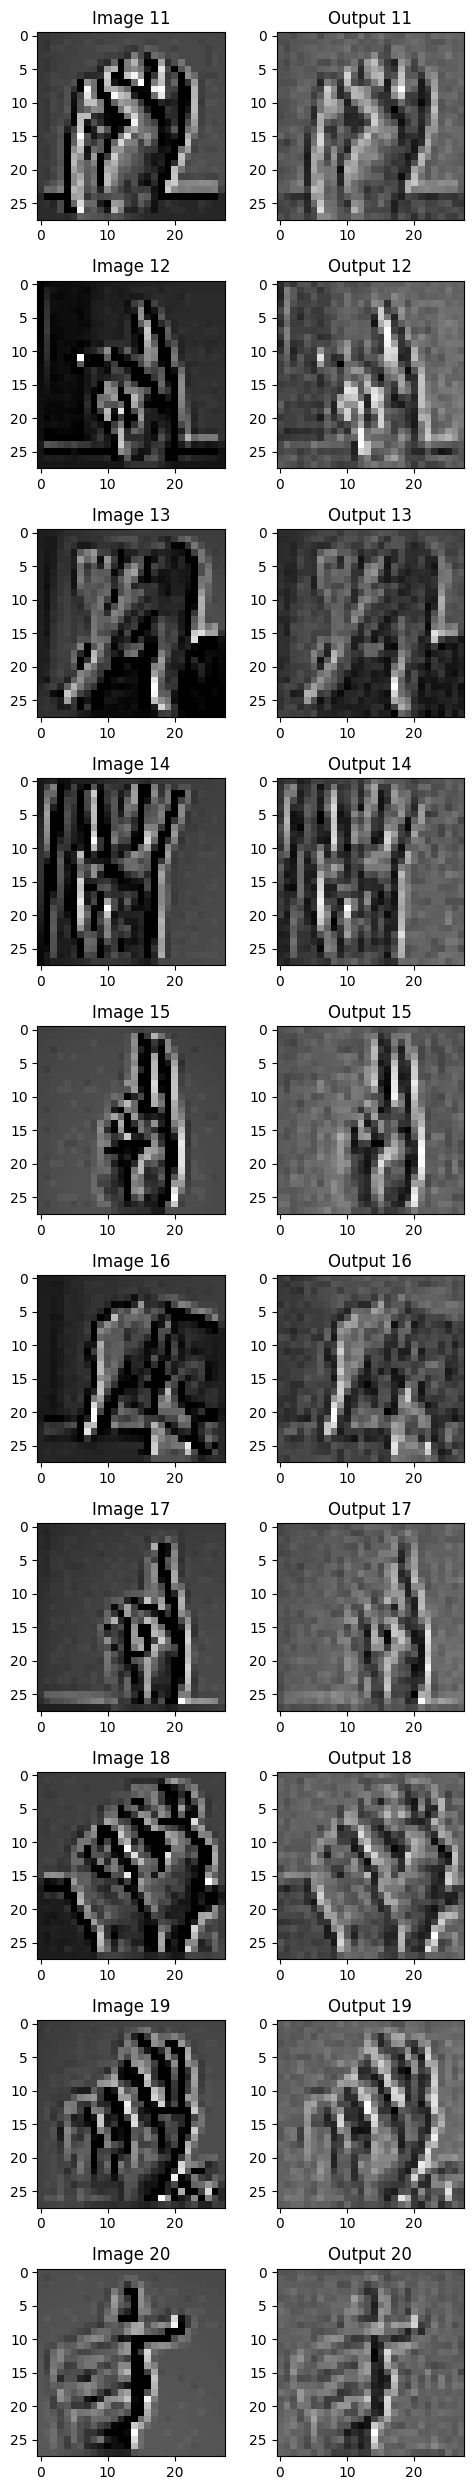

In [45]:
plt.figure(figsize=(5, 25))
start = 10
for i in range(start,start+10):
    plt.subplot(10, 2, 2*(i-start)+1)
    plt.imshow(images[i].cpu().squeeze(0), cmap='gray')
    plt.title(f'Image {i+1}')
    
    plt.subplot(10, 2, 2*(i-start)+2)
    plt.imshow(outputs[i].cpu().squeeze(0), cmap='gray')
    plt.title(f'Output {i+1}')

plt.tight_layout()
plt.show()

In [55]:
with torch.no_grad():
    latent_space = model.encode(images)

In [56]:
latent_space.max(0), latent_space.min(0)

(torch.return_types.max(
 values=tensor([44.1130, 40.8885, 41.1336, 42.4887, 40.7613, 38.5323, 33.6395, 35.3769,
         44.2675, 42.5168], device='cuda:0'),
 indices=tensor([ 8278, 25034,  4601,  4172, 15389, 23934, 12050, 22292, 32672,  9235],
        device='cuda:0')),
 torch.return_types.min(
 values=tensor([-42.4239, -32.3655, -32.6723, -40.7725, -37.6149, -36.1698, -41.2930,
         -45.5128, -34.4796, -35.1466], device='cuda:0'),
 indices=tensor([31600,  2920, 31489,  4912, 32031,  1782,  5414, 12321,  1252, 31856],
        device='cuda:0')))

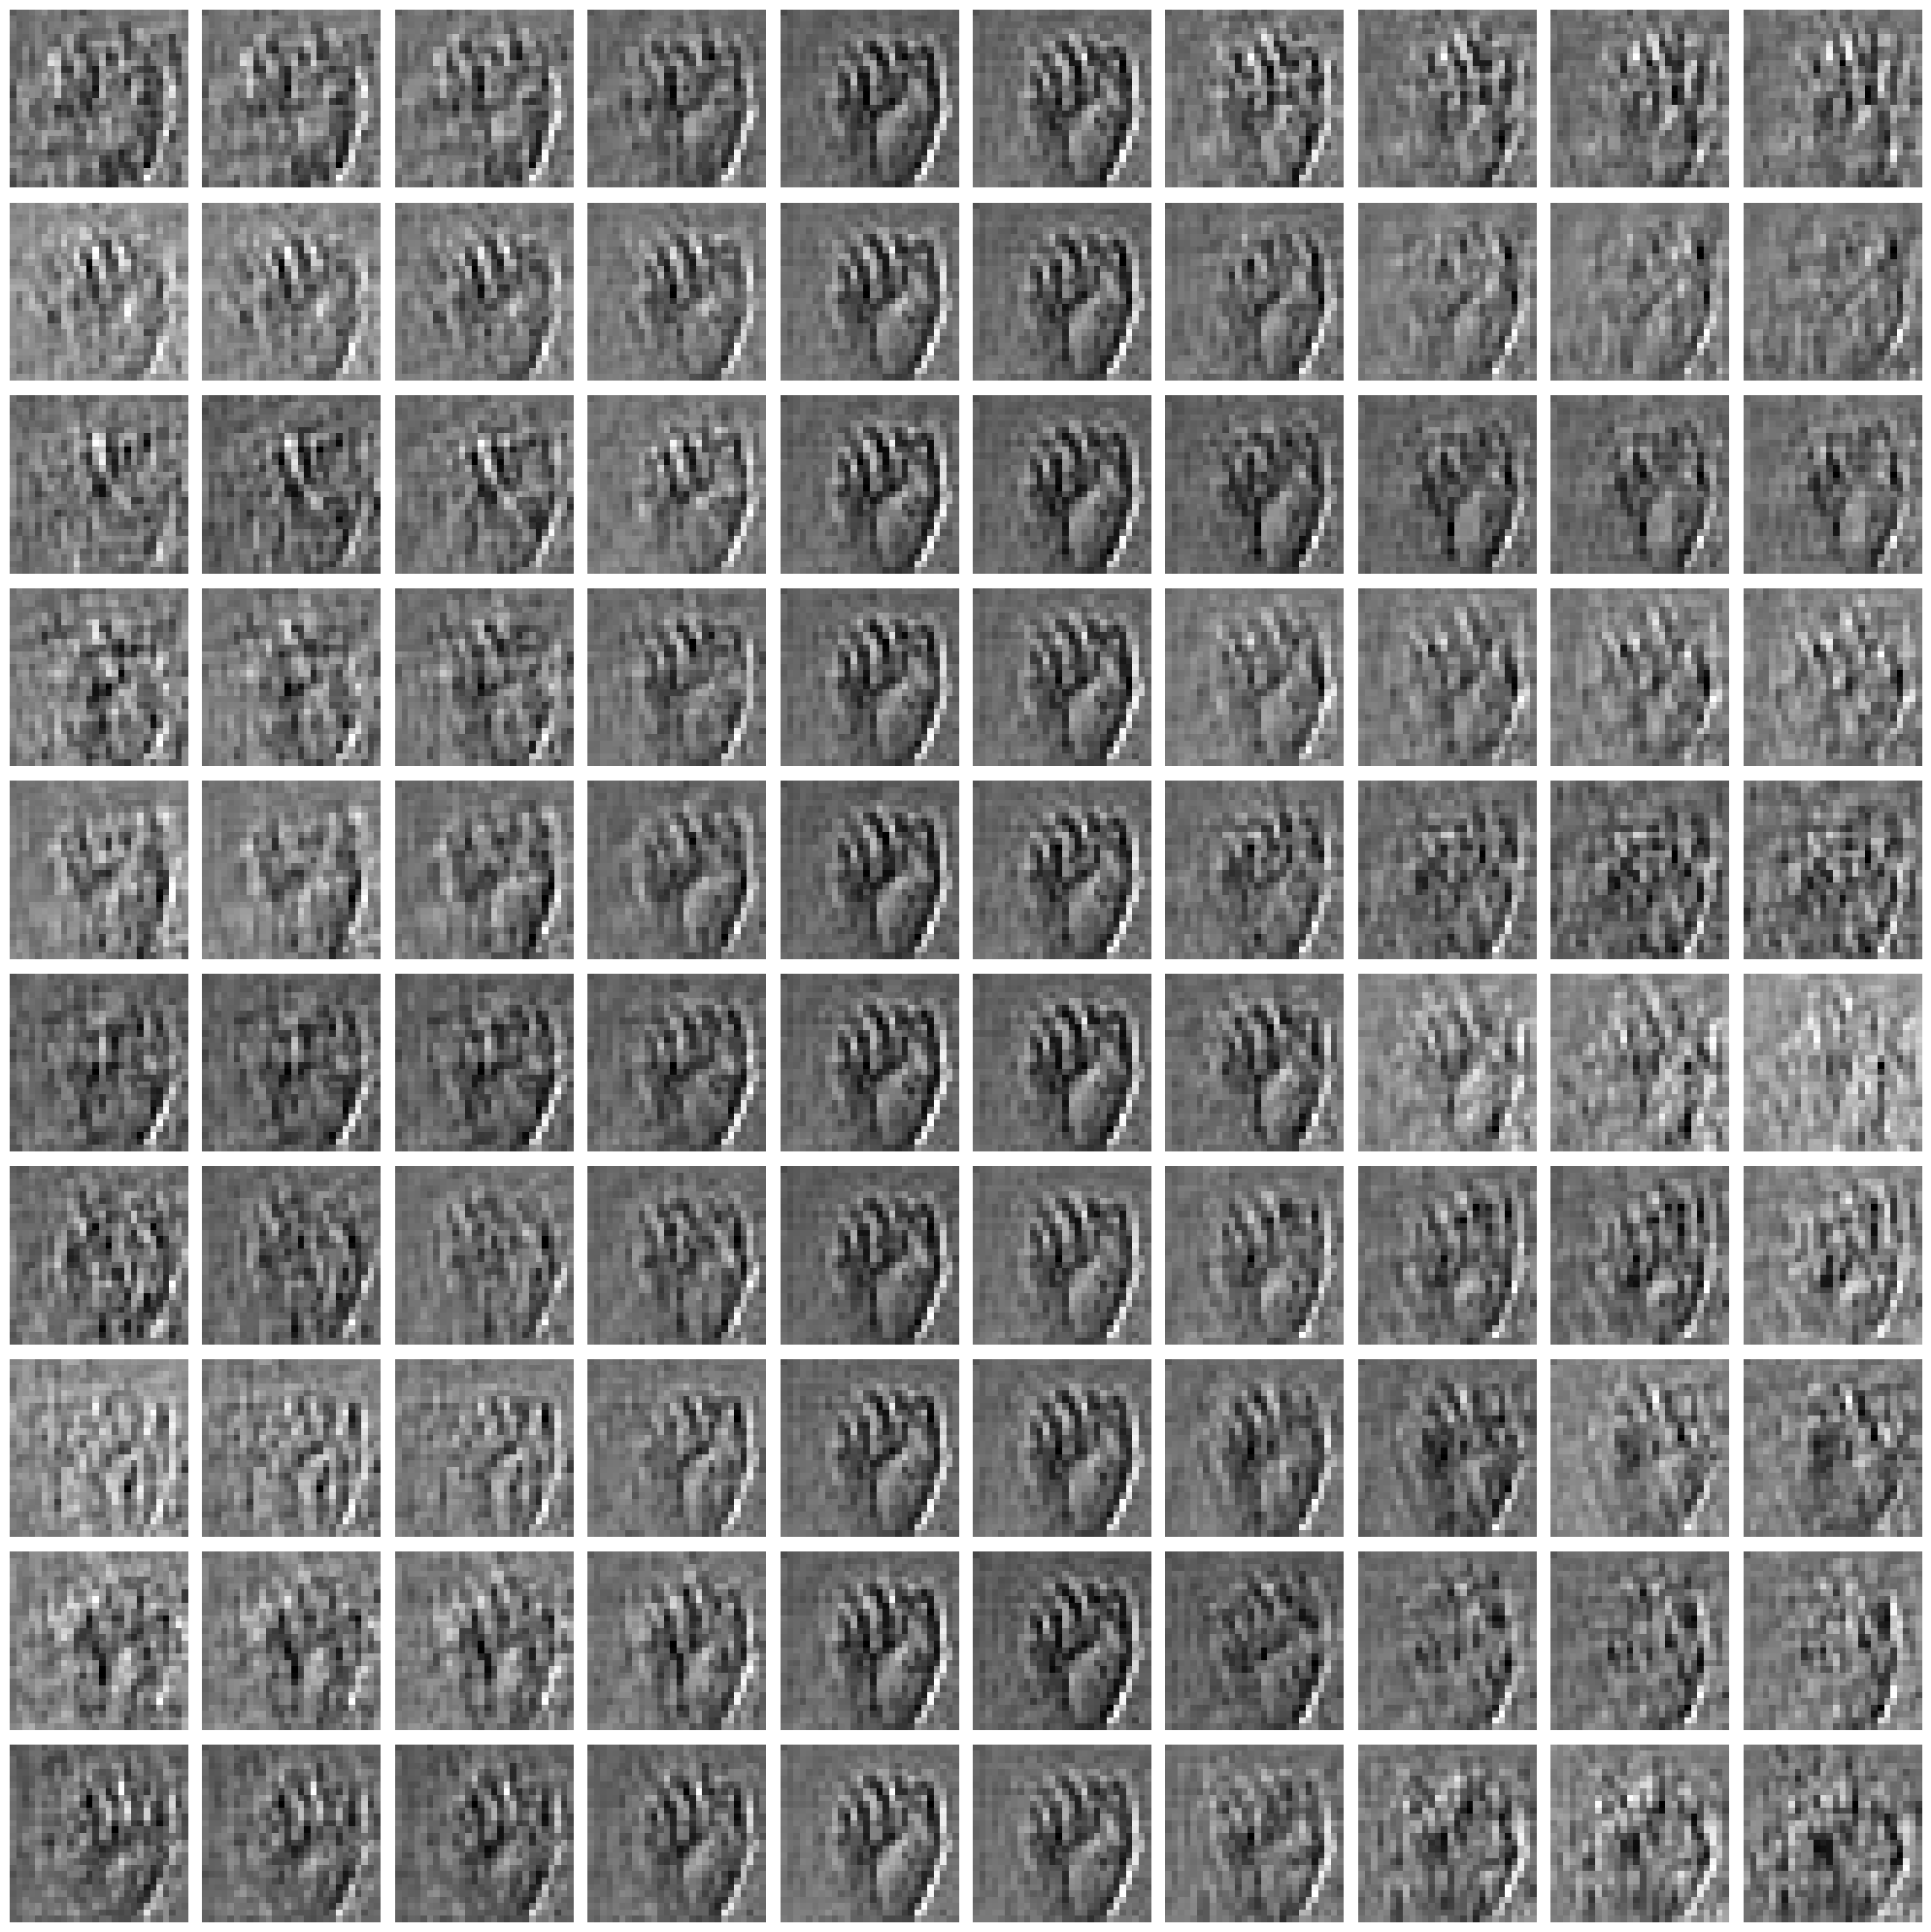

In [61]:
import numpy as np
import torch
import matplotlib.pyplot as plt

img_index = 20

# Assuming you already have defined the following:
# latent_space, device, model

# Create a figure
plt.figure(figsize=(20, 20))  # Adjust the size to fit 10x10 images

start = -20
stop = 20
values  = np.linspace(start, stop, 10)

# Loop over each dimension
for dim in range(10):
    
    # Loop over each value to be added
    for i, value in enumerate(values):
        value = int(value)
        
        # Create a tensor with only the current dimension modified
        change_tensor = torch.zeros(10).to(device)
        change_tensor[dim] = value
        
        good_embedding = latent_space[img_index] + change_tensor
        
        with torch.no_grad():
            decoded_image = model.decode(good_embedding.unsqueeze(0)).squeeze((0, 1)).cpu().numpy()
            
            # Plot the image in a subplot
            plt.subplot(10, 10, dim*10 + i + 1)
            plt.imshow(decoded_image, cmap='gray')
            plt.axis('off')  # Hide axis

plt.tight_layout()
plt.show()
